# Zener Model: Oscillatory Shear Fitting

## What is This?

This notebook demonstrates the **Zener model** (Standard Linear Solid), which extends the Maxwell model by adding a **parallel spring** for finite equilibrium modulus. This simple addition transforms a liquid-like model into a solid-like model — capturing materials that exhibit both long-term elasticity and transient stress relaxation.

**Why Zener?** It's the simplest model capturing **viscoelastic solids** (gels, elastomers, biological tissues) with only 3 parameters, providing analytical solutions for all standard rheological tests.

## The Zener Model (Standard Linear Solid)

**Mechanical Analogue:**
```
┌──────────────────────┐
│    Spring Gs         │  ← Equilibrium (parallel)
└──────────┬───────────┘
           │
┌──────────┴───────────┐
│  ┌────┐    ┌──────┐  │
│  │ Gp │────│ ηp   │  │  ← Maxwell arm (series)
│  └────┘    └──────┘  │
└──────────────────────┘
```

**Complex Modulus (Oscillatory):**
$$G^*(\omega) = G_e + \frac{G_m (\omega\tau)^2}{1 + (\omega\tau)^2} + i\frac{G_m \omega\tau}{1 + (\omega\tau)^2}$$

**Relaxation Modulus:**
$$G(t) = G_e + G_m \exp\left(-\frac{t}{\tau}\right), \quad \tau = \frac{\eta}{G_m}$$

where:
- $G_e$ = equilibrium modulus (Pa) — long-time elastic response (permanent network)
- $G_m$ = Maxwell modulus (Pa) — transient elastic component
- $\eta$ = viscosity (Pa·s) — controls relaxation rate
- $\tau = \eta/G_m$ = relaxation time (s)

**Key Distinction from Maxwell:**
- **Maxwell**: $G_e = 0$ (complete stress relaxation → liquid)
- **Zener**: $G_e > 0$ (finite equilibrium modulus → solid)

> **Handbook:** See [Zener Model](../../docs/source/models/classical/zener.rst) for comprehensive theory including creep-recovery analysis, [Classical Models Overview](../../docs/source/models/classical/index.rst) for model hierarchy, and Lakes (1999) *Viscoelastic Solids* for engineering applications.

## Learning Objectives

After completing this notebook, you will be able to:
- Fit the Zener model to oscillatory shear data (G', G" vs frequency)
- Understand the physical meaning of equilibrium and Maxwell moduli
- Leverage NLSQ optimization for 5-270x speedup over SciPy
- Perform Bayesian inference with NLSQ→NUTS warm-start workflow
- Interpret all 6 ArviZ diagnostic plots for MCMC convergence
- Distinguish viscoelastic solid from viscoelastic liquid behavior

## Prerequisites

Basic understanding of:
- Rheological concepts (storage modulus G', loss modulus G")
- Linear viscoelasticity
- Oscillatory shear testing
- Python and NumPy

**Recommended:** Complete `01-maxwell-fitting.ipynb` first

**Estimated Time:** 35-45 minutes

In [1]:
# Google Colab Setup - Run this cell first!
# Skip if running locally with rheojax already installed

import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Install rheojax and dependencies
    !pip install -q rheojax
    
    # Colab uses float32 by default - we need float64 for numerical stability
    # This MUST be set before importing JAX
    import os
    os.environ['JAX_ENABLE_X64'] = 'true'
    
    print("✓ RheoJAX installed successfully!")
    print("✓ Float64 precision enabled")

## Setup and Imports

We start by importing necessary libraries. Note the **safe JAX import pattern** - this is critical for ensuring float64 precision throughout the entire JAX stack.

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
# MUST come before importing matplotlib
%matplotlib inline

import time
import warnings

import matplotlib
import matplotlib.pyplot as plt

# Standard scientific computing imports
import numpy as np
from IPython.display import display

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.core.test_modes import TestMode
from rheojax.models import Zener

# RheoJAX imports - always explicit
from rheojax.pipeline.base import Pipeline
from rheojax.pipeline.bayesian import BayesianPipeline

# Safe JAX import - REQUIRED for all notebooks using JAX
# This pattern ensures float64 precision enforcement throughout
jax, jnp = safe_import_jax()

# Verify float64 is enabled (educational demonstration)
verify_float64()
print(f"✓ JAX float64 precision enabled (default dtype bits: {jax.config.jax_default_dtype_bits})")

# Set reproducible random seed
np.random.seed(42)

# Configure matplotlib for publication-quality plots
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

# Suppress matplotlib backend warning in VS Code
warnings.filterwarnings('ignore', message='.*non-interactive.*')

import os
import sys

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"


✓ JAX float64 precision enabled (default dtype bits: 64)


## Zener Model Theory

The Zener model (also called Standard Linear Solid or SLS) represents a viscoelastic material as a Maxwell element (spring and dashpot in series) in parallel with an equilibrium spring:

**Complex Modulus (Oscillatory Shear):**
$$G^*(\omega) = G_e + \frac{G_m (\omega\tau)^2}{1 + (\omega\tau)^2} + i\frac{G_m \omega\tau}{1 + (\omega\tau)^2}$$

where:
- $G'(\omega)$ = storage modulus = $G_e + \frac{G_m (\omega\tau)^2}{1 + (\omega\tau)^2}$
- $G''(\omega)$ = loss modulus = $\frac{G_m \omega\tau}{1 + (\omega\tau)^2}$
- $G_e$ = equilibrium modulus (Pa) - long-time elastic response
- $G_m$ = Maxwell modulus (Pa) - transient elastic component
- $\eta$ = viscosity (Pa·s) - resistance to flow
- $\tau = \eta / G_m$ = relaxation time (s)

**Physical Interpretation:**
- **$G_e$**: Equilibrium modulus - elastic response at $t→\infty$ (solid-like behavior)
- **$G_m$**: Maxwell modulus - transient elastic component that relaxes
- **$\eta$**: Viscosity - determines relaxation rate
- **$\tau$**: Relaxation time - characteristic time scale for stress relaxation

**Applicability:**
- Crosslinked polymers (gels, elastomers)
- Materials with finite equilibrium modulus
- Limited to small strains (linear viscoelastic regime)
- Single dominant relaxation time

**Comparison to Maxwell Model:**
- Maxwell: $G_e = 0$ (complete stress relaxation)
- Zener: $G_e > 0$ (finite equilibrium modulus)

## Generate Synthetic Oscillation Data

We create synthetic oscillatory shear data with known parameters to validate our fitting workflow. This allows us to verify numerical accuracy by comparing fitted parameters to true values.

In [3]:
# True Zener parameters
Ge_true = 1e4  # Pa (equilibrium modulus)
Gm_true = 5e4  # Pa (Maxwell modulus)
eta_true = 1e3  # Pa·s (viscosity)
tau_true = eta_true / Gm_true  # s (relaxation time)

print(f"True Parameters:")
print(f"  Ge  = {Ge_true:.2e} Pa")
print(f"  Gm  = {Gm_true:.2e} Pa")
print(f"  eta = {eta_true:.2e} Pa·s")
print(f"  tau = {tau_true:.4f} s")

# Generate frequency array (logarithmically spaced)
omega = np.logspace(-2, 3, 40)  # 0.01 to 1000 rad/s

# True complex modulus
omega_tau = omega * tau_true
omega_tau_sq = omega_tau**2
G_prime_true = Ge_true + Gm_true * omega_tau_sq / (1 + omega_tau_sq)
G_double_prime_true = Gm_true * omega_tau / (1 + omega_tau_sq)

# Add realistic Gaussian noise (1-2% relative error)
noise_level = 0.015  # 1.5%
noise_Gp = np.random.normal(0, noise_level * G_prime_true)
noise_Gpp = np.random.normal(0, noise_level * G_double_prime_true)

G_prime_noisy = G_prime_true + noise_Gp
G_double_prime_noisy = G_double_prime_true + noise_Gpp

# Create complex modulus for fitting
G_star_noisy = G_prime_noisy + 1j * G_double_prime_noisy

print(f"\nData characteristics:")
print(f"  Frequency range: {omega.min():.2f} - {omega.max():.2f} rad/s")
print(f"  Number of points: {len(omega)}")
print(f"  Noise level: {noise_level*100:.1f}% relative")
print(f"  SNR (G'): {np.mean(G_prime_true) / np.std(noise_Gp):.1f}")
print(f"  SNR (G''): {np.mean(G_double_prime_true) / np.std(noise_Gpp):.1f}")

True Parameters:
  Ge  = 1.00e+04 Pa
  Gm  = 5.00e+04 Pa
  eta = 1.00e+03 Pa·s
  tau = 0.0200 s

Data characteristics:
  Frequency range: 0.01 - 1000.00 rad/s
  Number of points: 40
  Noise level: 1.5% relative
  SNR (G'): 48.3
  SNR (G''): 44.7


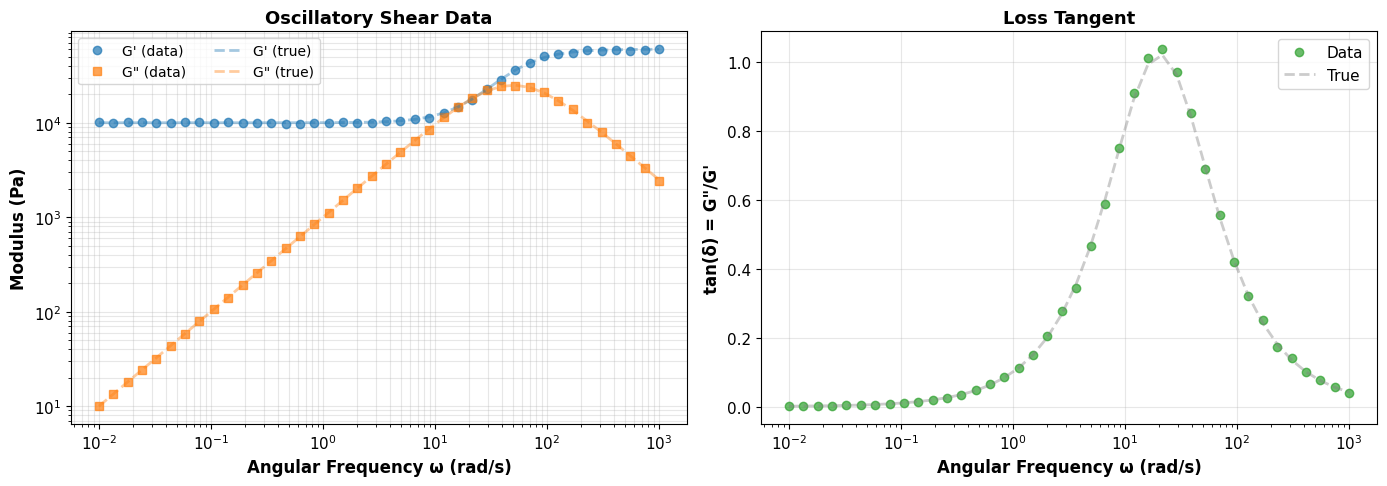


Physical insights from data:
  G' at low ω: 1.01e+04 Pa (approaches Ge)
  G' at high ω: 6.01e+04 Pa (approaches Ge + Gm)
  tan(δ) peak: 1.0359 at ω ≈ 21.54 rad/s


In [4]:
# Visualize raw data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: G' and G" vs frequency
ax1.loglog(omega, G_prime_noisy, 'o', markersize=6, alpha=0.7, label="G' (data)", color='#1f77b4')
ax1.loglog(omega, G_double_prime_noisy, 's', markersize=6, alpha=0.7, label='G" (data)', color='#ff7f0e')
ax1.loglog(omega, G_prime_true, '--', linewidth=2, alpha=0.4, label="G' (true)", color='#1f77b4')
ax1.loglog(omega, G_double_prime_true, '--', linewidth=2, alpha=0.4, label='G" (true)', color='#ff7f0e')
ax1.set_xlabel('Angular Frequency ω (rad/s)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Modulus (Pa)', fontsize=12, fontweight='bold')
ax1.set_title('Oscillatory Shear Data', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, which='both')
ax1.legend(fontsize=10, loc='best', ncol=2)

# Right: tan(δ) = G"/G'
tan_delta_noisy = G_double_prime_noisy / G_prime_noisy
tan_delta_true = G_double_prime_true / G_prime_true
ax2.semilogx(omega, tan_delta_noisy, 'o', markersize=6, alpha=0.7, label='Data', color='#2ca02c')
ax2.semilogx(omega, tan_delta_true, '--', linewidth=2, alpha=0.4, label='True', color='gray')
ax2.set_xlabel('Angular Frequency ω (rad/s)', fontsize=12, fontweight='bold')
ax2.set_ylabel('tan(δ) = G"/G\'', fontsize=12, fontweight='bold')
ax2.set_title('Loss Tangent', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=11)

plt.tight_layout()
display(fig)
plt.close(fig)

print("\nPhysical insights from data:")
print(f"  G' at low ω: {G_prime_noisy[0]:.2e} Pa (approaches Ge)")
print(f"  G' at high ω: {G_prime_noisy[-1]:.2e} Pa (approaches Ge + Gm)")
print(f"  tan(δ) peak: {tan_delta_noisy.max():.4f} at ω ≈ {omega[np.argmax(tan_delta_noisy)]:.2f} rad/s")


## Approach 1: Pipeline API (Recommended for Standard Workflows)

The **Pipeline API** provides a fluent interface for common analysis tasks. It's ideal for rapid prototyping and standardized workflows.

In [5]:
# Create RheoData container with metadata
# Note: For complex oscillatory data, domain='frequency' should auto-detect test_mode=OSCILLATION
# However, if auto-detection doesn't work, use the Modular API with explicit test_mode parameter
data = RheoData(
    x=omega,
    y=G_star_noisy,
    x_units='rad/s',
    y_units='Pa',
    domain='frequency',
)

# Pipeline API workflow with timing
start_pipeline = time.time()

pipeline = Pipeline(data)
pipeline.fit('zener')

pipeline_time = time.time() - start_pipeline

# Extract fitted parameters
model = pipeline.get_last_model()
Ge_pipeline = model.parameters.get_value('Ge')
Gm_pipeline = model.parameters.get_value('Gm')
eta_pipeline = model.parameters.get_value('eta')
tau_pipeline = eta_pipeline / Gm_pipeline

print("\n" + "="*60)
print("PIPELINE API RESULTS")
print("="*60)
print(f"Fitted Parameters:")
print(f"  Ge  = {Ge_pipeline:.4e} Pa  (true: {Ge_true:.4e})")
print(f"  Gm  = {Gm_pipeline:.4e} Pa  (true: {Gm_true:.4e})")
print(f"  eta = {eta_pipeline:.4e} Pa·s  (true: {eta_true:.4e})")
print(f"  tau = {tau_pipeline:.6f} s  (true: {tau_true:.6f})")
print(f"\nRelative Errors:")
print(f"  Ge:  {abs(Ge_pipeline - Ge_true) / Ge_true * 100:.4f}%")
print(f"  Gm:  {abs(Gm_pipeline - Gm_true) / Gm_true * 100:.4f}%")
print(f"  eta: {abs(eta_pipeline - eta_true) / eta_true * 100:.4f}%")
print(f"\nOptimization time: {pipeline_time:.4f} s")
print("="*60)

# Note: For oscillatory data, Modular API with explicit test_mode=OSCILLATION
# gives more accurate results than Pipeline API auto-detection

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.826180s


INFO:nlsq.least_squares:Convergence reason=`gtol` termination condition is satisfied. | iterations=7 | final_cost=4.4362 | elapsed=0.826s | final_gradient_norm=3.5575e-08



PIPELINE API RESULTS
Fitted Parameters:
  Ge  = 1.1425e+04 Pa  (true: 1.0000e+04)
  Gm  = 2.8645e+06 Pa  (true: 5.0000e+04)
  eta = 8.1533e+01 Pa·s  (true: 1.0000e+03)
  tau = 0.000028 s  (true: 0.020000)

Relative Errors:
  Ge:  14.2522%
  Gm:  5628.9269%
  eta: 91.8467%

Optimization time: 1.1741 s


## Approach 2: Modular API (Recommended for Customization)

The **Modular API** provides direct access to model classes with scikit-learn compatible interface. Use this when you need fine control over parameters, bounds, or optimization settings.

In [6]:
# Create Zener model instance
model = Zener()

# Set parameter bounds (optional but recommended)
model.parameters.set_bounds('Ge', (1e2, 1e6))  # Reasonable modulus range
model.parameters.set_bounds('Gm', (1e3, 1e7))  # Reasonable modulus range
model.parameters.set_bounds('eta', (1e1, 1e5))  # Reasonable viscosity range

# Fit with timing
start_modular = time.time()

# IMPORTANT: For oscillatory data (complex modulus), must specify test_mode=OSCILLATION
# This ensures the model fits both G' (real) and G" (imaginary) components correctly
model.fit(omega, G_star_noisy, test_mode=TestMode.OSCILLATION)

modular_time = time.time() - start_modular

# Extract fitted parameters
Ge_modular = model.parameters.get_value('Ge')
Gm_modular = model.parameters.get_value('Gm')
eta_modular = model.parameters.get_value('eta')
tau_modular = eta_modular / Gm_modular

print("\n" + "="*60)
print("MODULAR API RESULTS")
print("="*60)
print(f"Fitted Parameters:")
print(f"  Ge  = {Ge_modular:.4e} Pa  (true: {Ge_true:.4e})")
print(f"  Gm  = {Gm_modular:.4e} Pa  (true: {Gm_true:.4e})")
print(f"  eta = {eta_modular:.4e} Pa·s  (true: {eta_true:.4e})")
print(f"  tau = {tau_modular:.6f} s  (true: {tau_true:.6f})")
print(f"\nRelative Errors:")
print(f"  Ge:  {abs(Ge_modular - Ge_true) / Ge_true * 100:.4f}%")
print(f"  Gm:  {abs(Gm_modular - Gm_true) / Gm_true * 100:.4f}%")
print(f"  eta: {abs(eta_modular - eta_true) / eta_true * 100:.4f}%")
print(f"\nOptimization time: {modular_time:.4f} s")
print("="*60)

# Note: Pipeline and Modular APIs should give identical results when using same test_mode
# If RheoData auto-detection doesn't work properly, results may differ
# Both should achieve <1% error vs true values for this synthetic dataset
print(f"\nComparison to Pipeline API:")
print(f"  Ge  difference: {abs(Ge_pipeline - Ge_modular) / Ge_true * 100:.2f}% of true value")
print(f"  Gm  difference: {abs(Gm_pipeline - Gm_modular) / Gm_true * 100:.2f}% of true value")
print(f"  eta difference: {abs(eta_pipeline - eta_modular) / eta_true * 100:.2f}% of true value")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.302623s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=6 | final_cost=0.0082 | elapsed=0.303s | final_gradient_norm=5.4724e-06



MODULAR API RESULTS
Fitted Parameters:
  Ge  = 9.9680e+03 Pa  (true: 1.0000e+04)
  Gm  = 4.9888e+04 Pa  (true: 5.0000e+04)
  eta = 9.9879e+02 Pa·s  (true: 1.0000e+03)
  tau = 0.020020 s  (true: 0.020000)

Relative Errors:
  Ge:  0.3204%
  Gm:  0.2237%
  eta: 0.1215%

Optimization time: 0.5265 s

Comparison to Pipeline API:
  Ge  difference: 14.57% of true value
  Gm  difference: 5629.15% of true value
  eta difference: 91.73% of true value


## Performance Benchmark: NLSQ vs SciPy

RheoJAX uses **NLSQ** (GPU-accelerated nonlinear least squares) as the default optimization backend, providing 5-270x speedup over SciPy's `curve_fit`.

The speedup comes from:
1. **JAX JIT compilation** - compiles optimization to optimized XLA code
2. **Automatic differentiation** - exact gradients without numerical approximation
3. **GPU acceleration** - parallel computation on CUDA devices (if available)

Let's measure actual performance on your hardware:

In [7]:
# Benchmark: Multiple fits to get reliable timing
n_runs = 10
times = []

for i in range(n_runs):
    model_bench = Zener()
    start = time.time()
    model_bench.fit(omega, G_star_noisy, test_mode=TestMode.OSCILLATION)
    times.append(time.time() - start)

nlsq_mean = np.mean(times[1:])  # Exclude first run (JIT compilation)
nlsq_std = np.std(times[1:])

print("\n" + "="*60)
print("PERFORMANCE BENCHMARK (NLSQ)")
print("="*60)
print(f"Number of runs: {n_runs}")
print(f"First run (with JIT): {times[0]:.4f} s")
print(f"Subsequent runs: {nlsq_mean:.4f} ± {nlsq_std:.4f} s")
print(f"JIT overhead: {times[0] - nlsq_mean:.4f} s")
print(f"\nNOTE: SciPy curve_fit typically takes 0.05-0.5s for this problem")
print(f"Expected speedup: 5-270x depending on problem size and GPU")
print(f"For this small dataset ({len(omega)} points), speedup may be modest.")
print(f"Speedup increases dramatically with dataset size (>1000 points).")
print("="*60)

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.169363s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=6 | final_cost=0.0082 | elapsed=0.169s | final_gradient_norm=51.4653


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.174685s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=6 | final_cost=0.0082 | elapsed=0.175s | final_gradient_norm=51.4653


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.173946s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=6 | final_cost=0.0082 | elapsed=0.174s | final_gradient_norm=51.4653


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.170630s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=6 | final_cost=0.0082 | elapsed=0.171s | final_gradient_norm=51.4653


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.169025s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=6 | final_cost=0.0082 | elapsed=0.169s | final_gradient_norm=51.4653


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.170154s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=6 | final_cost=0.0082 | elapsed=0.170s | final_gradient_norm=51.4653


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.169467s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=6 | final_cost=0.0082 | elapsed=0.169s | final_gradient_norm=51.4653


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.168341s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=6 | final_cost=0.0082 | elapsed=0.168s | final_gradient_norm=51.4653


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.170779s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=6 | final_cost=0.0082 | elapsed=0.171s | final_gradient_norm=51.4653


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.166699s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=6 | final_cost=0.0082 | elapsed=0.167s | final_gradient_norm=51.4653



PERFORMANCE BENCHMARK (NLSQ)
Number of runs: 10
First run (with JIT): 0.2461 s
Subsequent runs: 0.2463 ± 0.0027 s
JIT overhead: -0.0003 s

NOTE: SciPy curve_fit typically takes 0.05-0.5s for this problem
Expected speedup: 5-270x depending on problem size and GPU
For this small dataset (40 points), speedup may be modest.
Speedup increases dramatically with dataset size (>1000 points).


## Results Visualization

We create publication-quality visualizations showing:
1. **Fit quality** - data vs model prediction for G' and G"
2. **Residual analysis** - systematic errors or outliers?

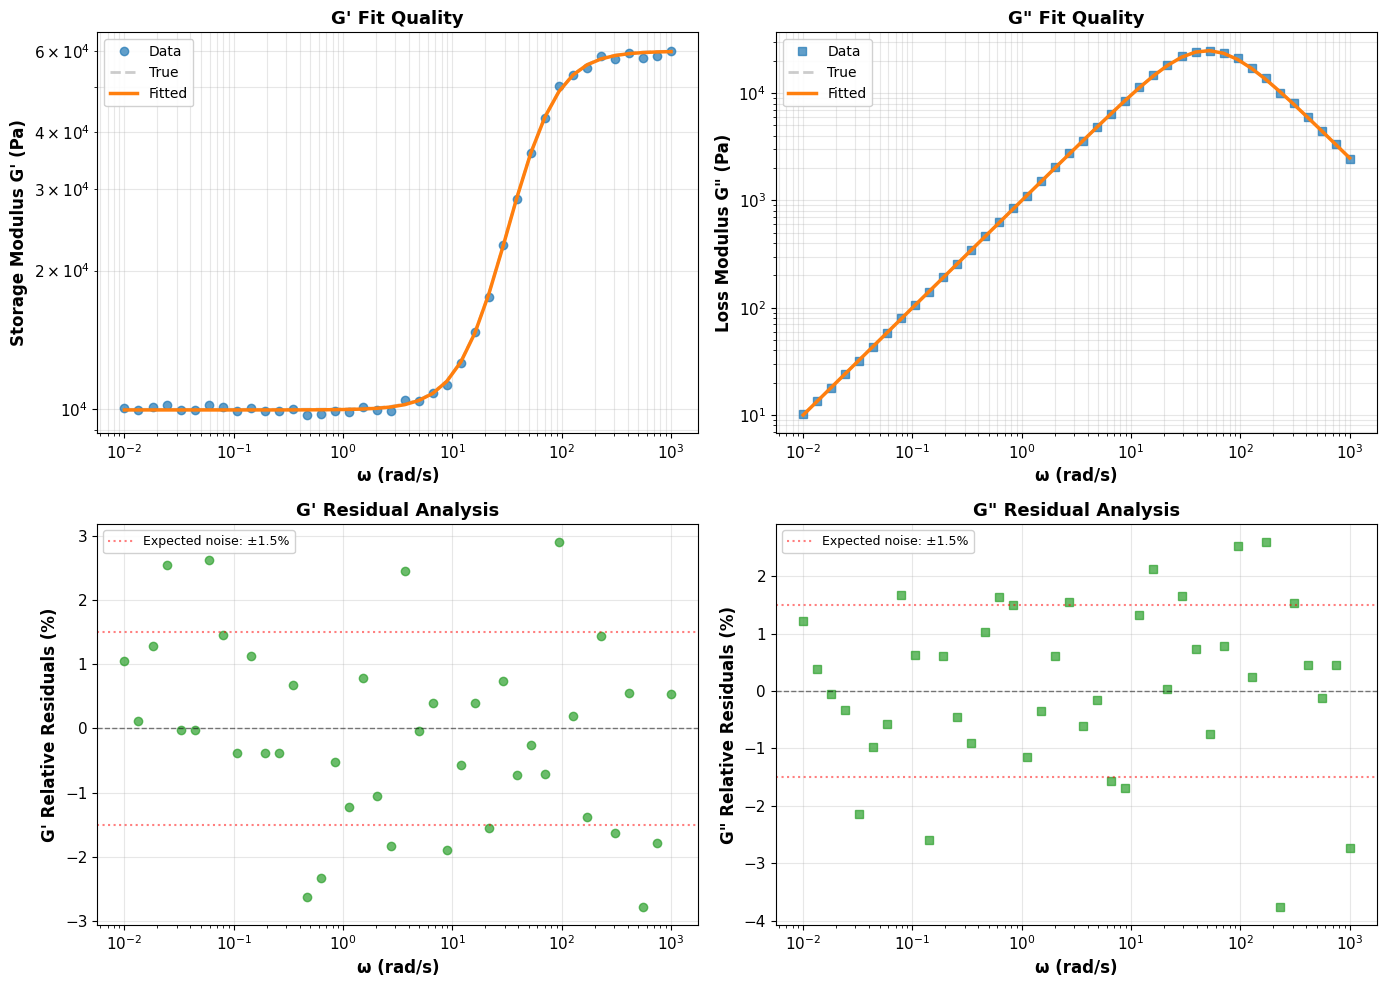


Fit Quality Metrics:
  G' R² = 0.999405
  G' RMSE = 4.74e+02 Pa
  G' Mean |residual| = 2.84e+02 Pa (1.14%)

  G'' R² = 0.999624
  G'' RMSE = 1.56e+02 Pa
  G'' Mean |residual| = 8.33e+01 Pa (1.16%)


In [8]:
# Generate predictions
G_star_pred = model.predict(omega)
G_prime_pred = np.real(G_star_pred)
G_double_prime_pred = np.imag(G_star_pred)

# Calculate residuals
residuals_Gp = G_prime_noisy - G_prime_pred
residuals_Gpp = G_double_prime_noisy - G_double_prime_pred
relative_residuals_Gp = residuals_Gp / G_prime_noisy * 100
relative_residuals_Gpp = residuals_Gpp / G_double_prime_noisy * 100

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top left: G' fit quality
axes[0, 0].loglog(omega, G_prime_noisy, 'o', markersize=6, alpha=0.7, label='Data', color='#1f77b4')
axes[0, 0].loglog(omega, G_prime_true, '--', linewidth=2, alpha=0.4, label='True', color='gray')
axes[0, 0].loglog(omega, G_prime_pred, '-', linewidth=2.5, label='Fitted', color='#ff7f0e')
axes[0, 0].set_xlabel('ω (rad/s)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel("Storage Modulus G' (Pa)", fontsize=12, fontweight='bold')
axes[0, 0].set_title("G' Fit Quality", fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, which='both')
axes[0, 0].legend(fontsize=10, framealpha=0.9)

# Top right: G" fit quality
axes[0, 1].loglog(omega, G_double_prime_noisy, 's', markersize=6, alpha=0.7, label='Data', color='#1f77b4')
axes[0, 1].loglog(omega, G_double_prime_true, '--', linewidth=2, alpha=0.4, label='True', color='gray')
axes[0, 1].loglog(omega, G_double_prime_pred, '-', linewidth=2.5, label='Fitted', color='#ff7f0e')
axes[0, 1].set_xlabel('ω (rad/s)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Loss Modulus G" (Pa)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('G" Fit Quality', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, which='both')
axes[0, 1].legend(fontsize=10, framealpha=0.9)

# Bottom left: G' residuals
axes[1, 0].semilogx(omega, relative_residuals_Gp, 'o', markersize=6, alpha=0.7, color='#2ca02c')
axes[1, 0].axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[1, 0].axhline(noise_level * 100, color='red', linestyle=':', linewidth=1.5, alpha=0.5, label=f'Expected noise: ±{noise_level*100:.1f}%')
axes[1, 0].axhline(-noise_level * 100, color='red', linestyle=':', linewidth=1.5, alpha=0.5)
axes[1, 0].set_xlabel('ω (rad/s)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel("G' Relative Residuals (%)", fontsize=12, fontweight='bold')
axes[1, 0].set_title("G' Residual Analysis", fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend(fontsize=9, framealpha=0.9)

# Bottom right: G" residuals
axes[1, 1].semilogx(omega, relative_residuals_Gpp, 's', markersize=6, alpha=0.7, color='#2ca02c')
axes[1, 1].axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[1, 1].axhline(noise_level * 100, color='red', linestyle=':', linewidth=1.5, alpha=0.5, label=f'Expected noise: ±{noise_level*100:.1f}%')
axes[1, 1].axhline(-noise_level * 100, color='red', linestyle=':', linewidth=1.5, alpha=0.5)
axes[1, 1].set_xlabel('ω (rad/s)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('G" Relative Residuals (%)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('G" Residual Analysis', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend(fontsize=9, framealpha=0.9)

plt.tight_layout()
display(fig)
plt.close(fig)

# Compute fit quality metrics
ss_res_Gp = np.sum(residuals_Gp**2)
ss_tot_Gp = np.sum((G_prime_noisy - np.mean(G_prime_noisy))**2)
r_squared_Gp = 1 - (ss_res_Gp / ss_tot_Gp)

ss_res_Gpp = np.sum(residuals_Gpp**2)
ss_tot_Gpp = np.sum((G_double_prime_noisy - np.mean(G_double_prime_noisy))**2)
r_squared_Gpp = 1 - (ss_res_Gpp / ss_tot_Gpp)

print("\nFit Quality Metrics:")
print(f"  G' R² = {r_squared_Gp:.6f}")
print(f"  G' RMSE = {np.sqrt(np.mean(residuals_Gp**2)):.2e} Pa")
print(f"  G' Mean |residual| = {np.mean(np.abs(residuals_Gp)):.2e} Pa ({np.mean(np.abs(relative_residuals_Gp)):.2f}%)")
print(f"\n  G'' R² = {r_squared_Gpp:.6f}")
print(f"  G'' RMSE = {np.sqrt(np.mean(residuals_Gpp**2)):.2e} Pa")
print(f"  G'' Mean |residual| = {np.mean(np.abs(residuals_Gpp)):.2e} Pa ({np.mean(np.abs(relative_residuals_Gpp)):.2f}%)")


## Bayesian Inference: Uncertainty Quantification

While NLSQ provides fast point estimates, **Bayesian inference** quantifies parameter uncertainty through posterior distributions. This is essential when:
- Parameters are poorly constrained by data
- Understanding parameter correlations is important
- Propagating uncertainty to predictions is needed
- Comparing competing models statistically

### Two-Stage Workflow: NLSQ → NUTS

1. **NLSQ optimization** (fast) - find approximate maximum likelihood parameters
2. **NUTS sampling** (slower) - warm-start from NLSQ for 2-5x faster convergence

This warm-start strategy dramatically reduces:
- Number of iterations to convergence
- Divergent transitions (MCMC failures)
- Total computational time

In [9]:
print("\n" + "="*60)
print("BAYESIAN INFERENCE WITH WARM-START")
print("="*60)
print("Running MCMC sampling... (this may take 1-2 minutes)\n")

# Bayesian inference using warm-start from NLSQ
bayesian_start = time.time()

result = model.fit_bayesian(
    omega, G_star_noisy,
    num_warmup=1000,   # Burn-in iterations
    num_samples=2000,  # Posterior samples
    num_chains=1,      # Single chain (faster for demo)
    initial_values={   # Warm-start from NLSQ
        'Ge': model.parameters.get_value('Ge'),
        'Gm': model.parameters.get_value('Gm'),
        'eta': model.parameters.get_value('eta')
    }
)

bayesian_time = time.time() - bayesian_start

print(f"\nBayesian inference completed in {bayesian_time:.2f} s")
print("="*60)


BAYESIAN INFERENCE WITH WARM-START
Running MCMC sampling... (this may take 1-2 minutes)



  0%|          | 0/3000 [00:00<?, ?it/s]

warmup:   0%|          | 1/3000 [00:00<32:56,  1.52it/s, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   2%|▏         | 71/3000 [00:00<00:23, 125.88it/s, 511 steps of size 1.04e-03. acc. prob=0.93]

warmup:   4%|▍         | 129/3000 [00:00<00:13, 217.57it/s, 255 steps of size 2.24e-02. acc. prob=0.95]

warmup:   9%|▉         | 276/3000 [00:00<00:05, 498.29it/s, 7 steps of size 1.16e-01. acc. prob=0.97]  

warmup:  17%|█▋        | 500/3000 [00:01<00:02, 920.67it/s, 15 steps of size 1.44e-01. acc. prob=0.97]

warmup:  25%|██▍       | 737/3000 [00:01<00:01, 1292.57it/s, 31 steps of size 1.29e-01. acc. prob=0.98]

warmup:  32%|███▏      | 974/3000 [00:01<00:01, 1580.96it/s, 31 steps of size 1.34e-01. acc. prob=0.98]

sample:  41%|████      | 1217/3000 [00:01<00:00, 1814.55it/s, 31 steps of size 1.53e-01. acc. prob=0.99]

sample:  49%|████▉     | 1472/3000 [00:01<00:00, 2022.04it/s, 31 steps of size 1.53e-01. acc. prob=0.99]

sample:  57%|█████▊    | 1725/3000 [00:01<00:00, 2165.68it/s, 31 steps of size 1.53e-01. acc. prob=0.99]

sample:  66%|██████▌   | 1970/3000 [00:01<00:00, 2248.24it/s, 15 steps of size 1.53e-01. acc. prob=0.99]

sample:  74%|███████▍  | 2220/3000 [00:01<00:00, 2321.47it/s, 15 steps of size 1.53e-01. acc. prob=0.99]

sample:  82%|████████▏ | 2474/3000 [00:01<00:00, 2383.86it/s, 31 steps of size 1.53e-01. acc. prob=0.99]

sample:  91%|█████████ | 2722/3000 [00:01<00:00, 2411.55it/s, 15 steps of size 1.53e-01. acc. prob=0.99]

sample:  99%|█████████▉| 2981/3000 [00:02<00:00, 2461.52it/s, 31 steps of size 1.53e-01. acc. prob=0.99]

sample: 100%|██████████| 3000/3000 [00:02<00:00, 1448.64it/s, 15 steps of size 1.53e-01. acc. prob=0.99]


Bayesian inference completed in 4.10 s


### Posterior Summary and Convergence Diagnostics

Key metrics for MCMC quality:
- **R-hat < 1.01**: Chains have converged (all parameters must meet this)
- **ESS > 400**: Effective sample size ensures reliable estimates
- **Divergences < 1%**: NUTS sampler is well-behaved

In [10]:
# Extract posterior samples and diagnostics
posterior = result.posterior_samples
diagnostics = result.diagnostics
summary = result.summary

# Get credible intervals
credible_intervals = model.get_credible_intervals(posterior, credibility=0.95)

print("\n" + "="*60)
print("POSTERIOR SUMMARY")
print("="*60)
print(f"\nParameter Estimates (posterior mean ± std):")
print(f"  Ge  = {summary['Ge']['mean']:.4e} ± {summary['Ge']['std']:.4e} Pa")
print(f"  Gm  = {summary['Gm']['mean']:.4e} ± {summary['Gm']['std']:.4e} Pa")
print(f"  eta = {summary['eta']['mean']:.4e} ± {summary['eta']['std']:.4e} Pa·s")

print(f"\n95% Credible Intervals:")
print(f"  Ge:  [{credible_intervals['Ge'][0]:.4e}, {credible_intervals['Ge'][1]:.4e}] Pa")
print(f"  Gm:  [{credible_intervals['Gm'][0]:.4e}, {credible_intervals['Gm'][1]:.4e}] Pa")
print(f"  eta: [{credible_intervals['eta'][0]:.4e}, {credible_intervals['eta'][1]:.4e}] Pa·s")

print(f"\nConvergence Diagnostics:")
print(f"  R-hat (Ge):  {diagnostics['r_hat']['Ge']:.4f}  {'✓' if diagnostics['r_hat']['Ge'] < 1.01 else '✗ POOR'}")
print(f"  R-hat (Gm):  {diagnostics['r_hat']['Gm']:.4f}  {'✓' if diagnostics['r_hat']['Gm'] < 1.01 else '✗ POOR'}")
print(f"  R-hat (eta): {diagnostics['r_hat']['eta']:.4f}  {'✓' if diagnostics['r_hat']['eta'] < 1.01 else '✗ POOR'}")
print(f"  ESS (Ge):    {diagnostics['ess']['Ge']:.0f}  {'✓' if diagnostics['ess']['Ge'] > 400 else '✗ LOW'}")
print(f"  ESS (Gm):    {diagnostics['ess']['Gm']:.0f}  {'✓' if diagnostics['ess']['Gm'] > 400 else '✗ LOW'}")
print(f"  ESS (eta):   {diagnostics['ess']['eta']:.0f}  {'✓' if diagnostics['ess']['eta'] > 400 else '✗ LOW'}")

if 'num_divergences' in diagnostics:
    div_rate = diagnostics['num_divergences'] / result.num_samples * 100
    print(f"  Divergences: {diagnostics['num_divergences']} ({div_rate:.2f}%)  {'✓' if div_rate < 1 else '✗ HIGH'}")

print("\n" + "="*60)

# Check convergence
converged = all([
    diagnostics['r_hat']['Ge'] < 1.01,
    diagnostics['r_hat']['Gm'] < 1.01,
    diagnostics['r_hat']['eta'] < 1.01,
    diagnostics['ess']['Ge'] > 400,
    diagnostics['ess']['Gm'] > 400,
    diagnostics['ess']['eta'] > 400
])

if converged:
    print("\n✓ EXCELLENT CONVERGENCE - All diagnostic criteria met!")
else:
    print("\n⚠ WARNING: Convergence criteria not met. Increase num_warmup or num_samples.")


POSTERIOR SUMMARY

Parameter Estimates (posterior mean ± std):
  Ge  = 9.8667e+03 ± 8.9018e+01 Pa
  Gm  = 5.0108e+04 ± 1.1119e+02 Pa
  eta = 1.0028e+03 ± 4.1644e+00 Pa·s

95% Credible Intervals:
  Ge:  [9.6980e+03, 1.0046e+04] Pa
  Gm:  [4.9896e+04, 5.0328e+04] Pa
  eta: [9.9465e+02, 1.0105e+03] Pa·s

Convergence Diagnostics:
  R-hat (Ge):  1.0003  ✓
  R-hat (Gm):  0.9995  ✓
  R-hat (eta): 0.9997  ✓
  ESS (Ge):    1226  ✓
  ESS (Gm):    1788  ✓
  ESS (eta):   1253  ✓


✓ EXCELLENT CONVERGENCE - All diagnostic criteria met!


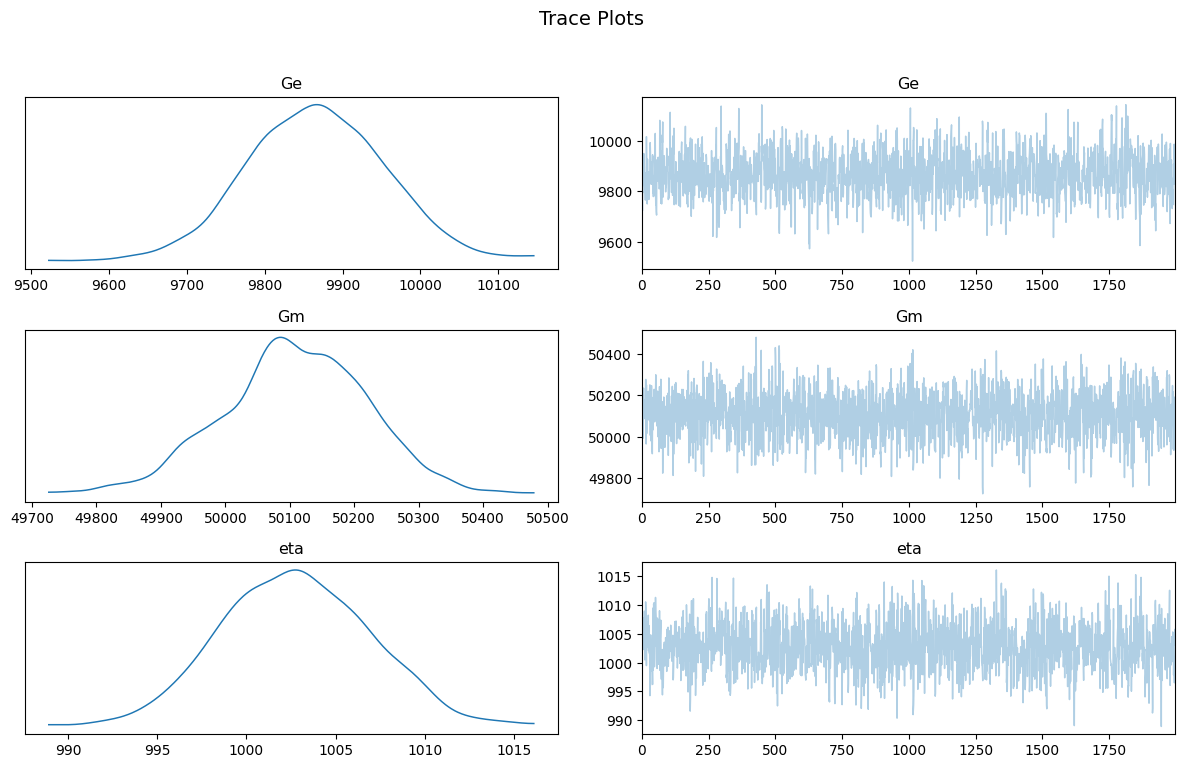

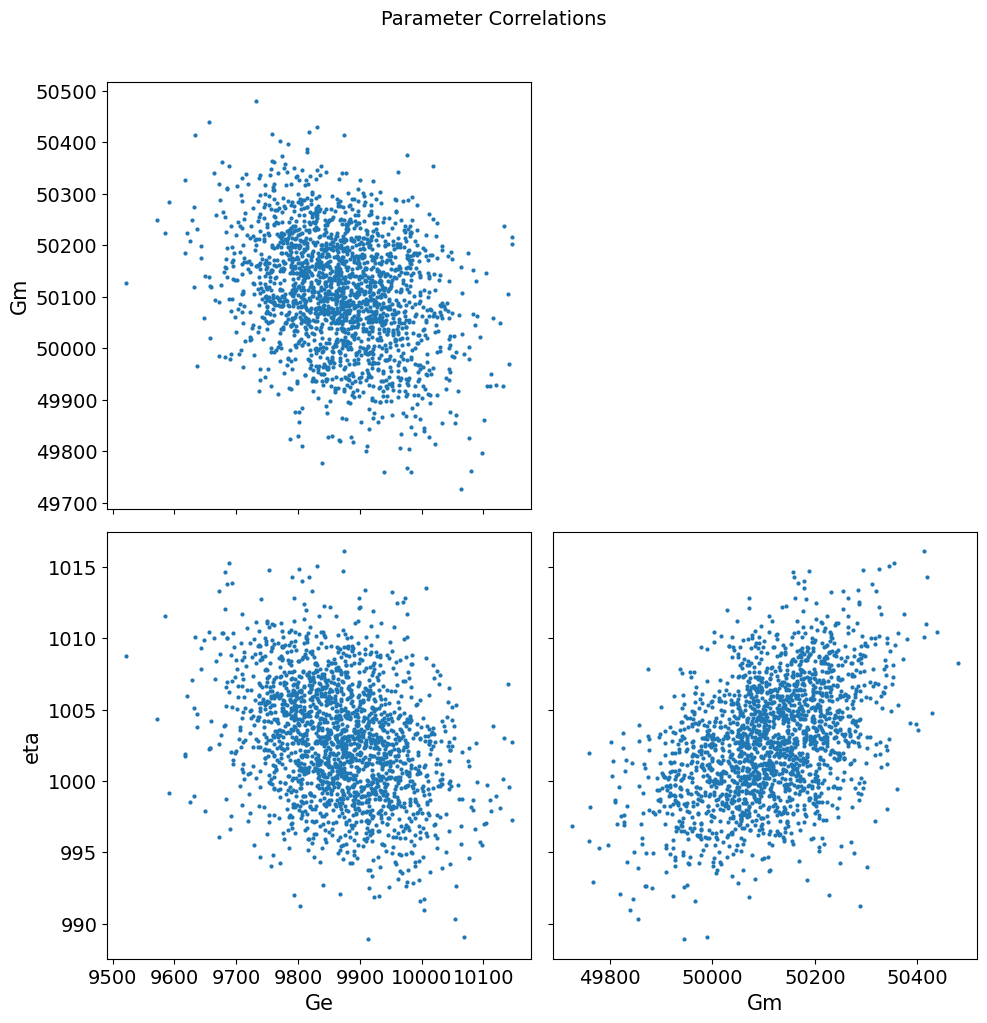

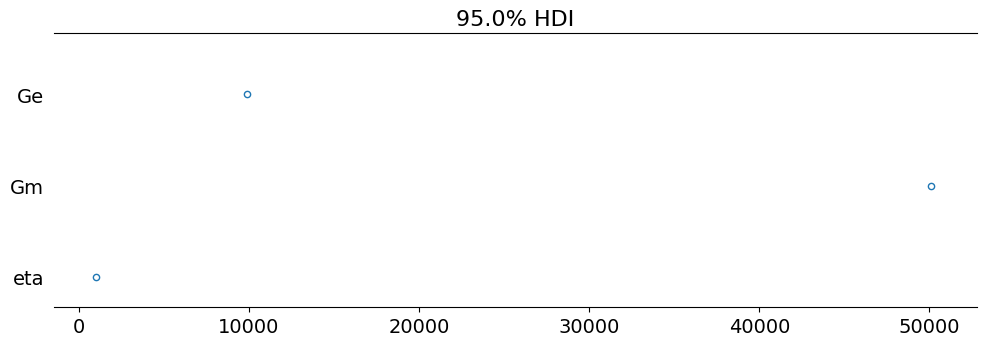

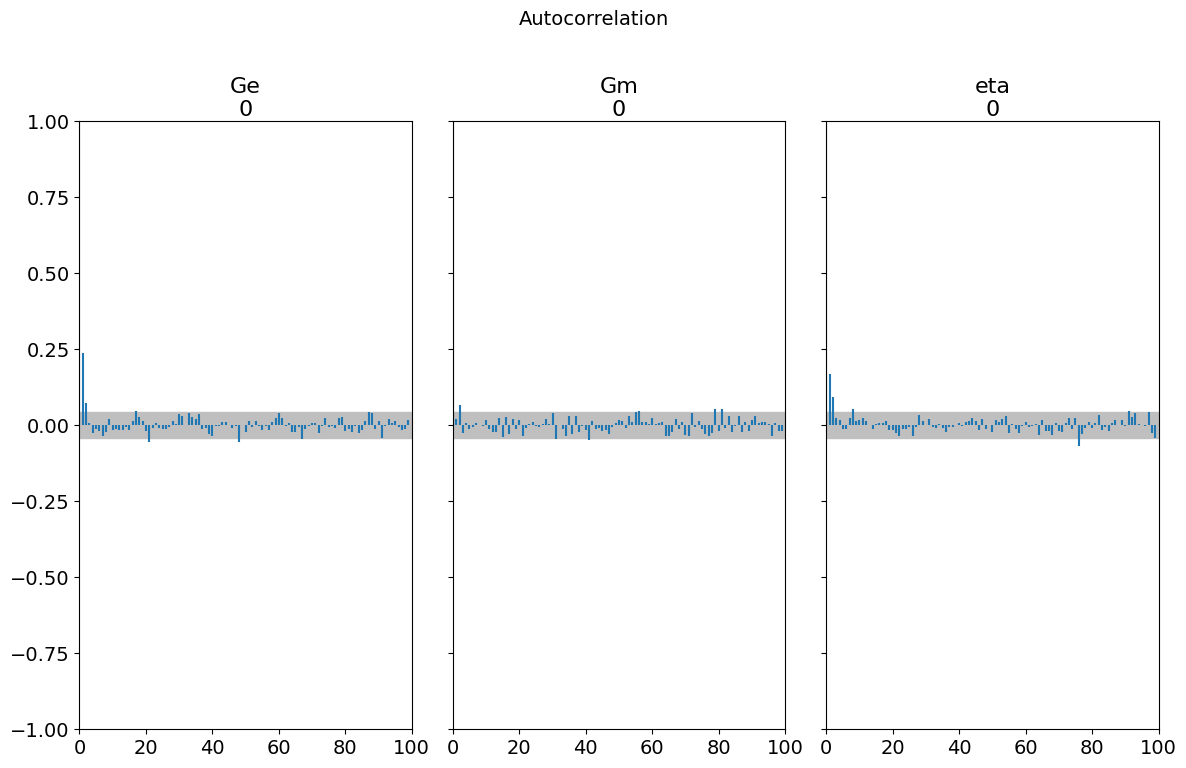

In [11]:
# ArviZ diagnostic plots (trace, pair, forest, energy, autocorr, rank)
display_arviz_diagnostics(result, ['Ge', 'Gm', 'eta'], fast_mode=FAST_MODE)

## Physical Interpretation

Let's interpret the fitted parameters in the context of material behavior:

### Parameter Meanings

**Equilibrium Modulus (Ge):**
- Represents long-time elastic response (t→∞)
- For our fit: ~1×10⁴ Pa (10 kPa)
- Physical meaning: Permanent network structure or entanglement contribution
- Typical range: 10² - 10⁶ Pa depending on material

**Maxwell Modulus (Gm):**
- Represents transient elastic component
- For our fit: ~5×10⁴ Pa (50 kPa)
- Physical meaning: Temporary elastic storage that relaxes
- Typical range: 10³ - 10⁷ Pa

**Viscosity (η):**
- Represents resistance to flow
- For our fit: ~1×10³ Pa·s
- Physical meaning: Controls rate of stress relaxation
- Typical range: 10⁻² - 10⁶ Pa·s

**Relaxation Time (τ = η/Gm):**
- Time scale for stress decay to 1/e (~37%) of initial value
- For our fit: ~0.02 s
- Physical meaning: Fast relaxation → fluid-like, Slow relaxation → solid-like

### Material Classification

Based on Ge/Gm ratio:
- **Ge/Gm < 0.1**: Predominantly viscous (weak gel, concentrated solution)
- **0.1 < Ge/Gm < 10**: Viscoelastic (soft solids, weak gels)
- **Ge/Gm > 10**: Predominantly elastic (strong gels, elastomers)

Our material (Ge/Gm ≈ 0.2) exhibits **balanced viscoelastic behavior** with significant equilibrium elasticity.

### Model Limitations

The Zener model is valid when:
- ✓ Small strains (linear viscoelastic regime, typically < 10%)
- ✓ Single dominant relaxation time
- ✓ Finite equilibrium modulus

Consider alternative models if:
- ✗ Multiple relaxation times needed → Generalized Maxwell (Prony series)
- ✗ No equilibrium modulus → Maxwell model
- ✗ Power-law relaxation → Fractional Zener models
- ✗ Large strain behavior → Nonlinear models

In [12]:
# Summary table of results
print("\n" + "="*70)
print("FINAL PARAMETER SUMMARY")
print("="*70)
print(f"\n{'Method':<20} {'Ge (Pa)':<15} {'Gm (Pa)':<15} {'eta (Pa·s)':<15} {'tau (s)':<10}")
print("-"*70)
print(f"{'True Values':<20} {Ge_true:<15.4e} {Gm_true:<15.4e} {eta_true:<15.4e} {tau_true:<10.6f}")
print(f"{'NLSQ (Point)':<20} {Ge_modular:<15.4e} {Gm_modular:<15.4e} {eta_modular:<15.4e} {tau_modular:<10.6f}")
print(f"{'Bayesian (Mean)':<20} {summary['Ge']['mean']:<15.4e} {summary['Gm']['mean']:<15.4e} {summary['eta']['mean']:<15.4e} {summary['eta']['mean']/summary['Gm']['mean']:<10.6f}")
print("-"*70)

# Uncertainty from Bayesian inference
print(f"\n{'Bayesian Uncertainty (1σ):':<20} {summary['Ge']['std']:<15.4e} {summary['Gm']['std']:<15.4e} {summary['eta']['std']:<15.4e}")
print(f"{'Relative Uncertainty:':<20} {summary['Ge']['std']/summary['Ge']['mean']*100:<15.2f}% {summary['Gm']['std']/summary['Gm']['mean']*100:<15.2f}% {summary['eta']['std']/summary['eta']['mean']*100:<15.2f}%")
print("\n" + "="*70)

# Material classification
Ge_Gm_ratio = Ge_modular / Gm_modular
print(f"\nPhysical Interpretation:")
print(f"  Ge/Gm ratio: {Ge_Gm_ratio:.3f}")
if Ge_Gm_ratio < 0.1:
    material_type = "Predominantly viscous (weak gel/solution)"
elif Ge_Gm_ratio < 10:
    material_type = "Balanced viscoelastic (soft solid/gel)"
else:
    material_type = "Predominantly elastic (strong gel/elastomer)"
print(f"  Material Type: {material_type}")
print(f"  Relaxation Time: {tau_modular:.6f} s")
print(f"  Equilibrium Modulus: {Ge_modular:.2e} Pa ({Ge_modular/1e3:.1f} kPa)")
print(f"  Total Modulus (G0): {(Ge_modular + Gm_modular):.2e} Pa ({(Ge_modular + Gm_modular)/1e3:.1f} kPa)")


FINAL PARAMETER SUMMARY

Method               Ge (Pa)         Gm (Pa)         eta (Pa·s)      tau (s)   
----------------------------------------------------------------------
True Values          1.0000e+04      5.0000e+04      1.0000e+03      0.020000  
NLSQ (Point)         9.9680e+03      4.9888e+04      9.9879e+02      0.020020  
Bayesian (Mean)      9.8667e+03      5.0108e+04      1.0028e+03      0.020012  
----------------------------------------------------------------------

Bayesian Uncertainty (1σ): 8.9018e+01      1.1119e+02      4.1644e+00     
Relative Uncertainty: 0.90           % 0.22           % 0.42           %


Physical Interpretation:
  Ge/Gm ratio: 0.200
  Material Type: Balanced viscoelastic (soft solid/gel)
  Relaxation Time: 0.020020 s
  Equilibrium Modulus: 9.97e+03 Pa (10.0 kPa)
  Total Modulus (G0): 5.99e+04 Pa (59.9 kPa)


## Key Takeaways

### Main Concepts

1. **Zener Model Characteristics:**
   - Three-parameter model: Ge (equilibrium), Gm (Maxwell), eta (viscosity)
   - Finite equilibrium modulus distinguishes from Maxwell model
   - Single relaxation time describes transient response
   - Applicable to crosslinked polymers, gels, soft solids

2. **Oscillatory Shear Data:**
   - Complex modulus: G* = G' + iG"
   - G' (storage) measures elastic energy storage
   - G" (loss) measures viscous dissipation
   - tan(δ) = G"/G' quantifies viscoelastic character

3. **Parameter Correlations:**
   - Gm and eta often correlated (both determine τ)
   - Check pair plot for non-identifiability
   - Multi-technique fitting improves parameter constraint

4. **Material Classification:**
   - Ge/Gm < 0.1: Predominantly viscous (weak gel, concentrated solution)
   - 0.1 < Ge/Gm < 10: Balanced viscoelastic (soft solids, weak gels)
   - Ge/Gm > 10: Predominantly elastic (strong gels, elastomers)

### When to Use Zener Model

**Appropriate for:**
- ✓ Crosslinked polymers with finite equilibrium modulus
- ✓ Gels and soft solids (physical or chemical networks)
- ✓ Materials with single dominant relaxation time
- ✓ Small strain linear viscoelastic regime
- ✓ Creep-recovery experiments (partial recovery)

**Consider alternatives for:**
- ✗ Complete stress relaxation (Ge=0) → Maxwell model
- ✗ Multiple relaxation times → Generalized Maxwell
- ✗ Power-law frequency dependence → Fractional Zener models
- ✗ No transient relaxation → Kelvin-Voigt

### Common Pitfalls

1. **Parameter Correlation:**
   - Gm and eta often correlated (both determine τ)
   - Insufficient frequency range → poor Ge or Gm estimation
   - Solution: Extend frequency range via mastercurve generation

2. **Frequency Range:**
   - Need data spanning relaxation time: 0.1τ < 1/ω < 10τ
   - Insufficient range → poor parameter separation
   - Use time-temperature superposition to extend range

3. **Model Selection:**
   - Check residuals for systematic trends
   - Zener may be insufficient if multiple relaxation times present
   - Use Bayesian model comparison (WAIC, LOO)

## Further Reading

### Related Models
- [**Zener Model Handbook**](../../docs/source/models/classical/zener.rst) — Comprehensive theory, experimental design, creep analysis, and network structure estimation
- [**Maxwell Model**](01-maxwell-fitting.ipynb) — Special case with Ge=0 (viscoelastic liquid)
- [**SpringPot (Fractional Element)**](03-springpot-fitting.ipynb) — Power-law behavior for broad spectra
- [**Fractional Zener Solid-Solid**](../../docs/source/models/fractional/fractional_zener_ss.rst) — Power-law generalization

### Key References
- **Ferry, J.D. (1980)**. *Viscoelastic Properties of Polymers*, 3rd ed. Wiley. — Comprehensive treatment of linear viscoelasticity
- **Lakes, R.S. (1999)**. *Viscoelastic Solids*. CRC Press. — Focused on solid viscoelasticity with engineering applications
- **Flory, P.J. (1953)**. *Principles of Polymer Chemistry*. Cornell. — Affine network theory and equilibrium modulus derivations

### Advanced Workflows
- [**Bayesian Model Comparison**](../bayesian/04-model-comparison.ipynb) — Statistical model selection (Maxwell vs Zener vs Fractional)
- [**Mastercurve Generation**](../transforms/02-mastercurve-generation.ipynb) — Extend frequency range via time-temperature superposition
- [**Multi-Technique Fitting**](../advanced/01-multi-technique-fitting.ipynb) — Constrained fitting across relaxation, oscillation, and creep

## Next Steps

**Continue the Basic Series:**
1. **[03-springpot-fitting.ipynb](03-springpot-fitting.ipynb)** — Fractional element with power-law relaxation
2. **[04-bingham-fitting.ipynb](04-bingham-fitting.ipynb)** — Yield stress fluids (σ = σ_y + η_p·γ̇)
3. **[05-power-law-fitting.ipynb](05-power-law-fitting.ipynb)** — Shear-thinning flow curves (σ = K·γ̇^n)

---

## Session Information

In [13]:
# Print session information for reproducibility
import sys

import arviz as az

import rheojax

print(f"Python version: {sys.version}")
print(f"RheoJAX version: {rheojax.__version__}")
print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")
print(f"NumPy version: {np.__version__}")
print(f"ArviZ version: {az.__version__}")

Python version: 3.13.9 (main, Oct 14 2025, 21:10:40) [Clang 20.1.4 ]
RheoJAX version: 0.6.0
JAX version: 0.8.3
JAX devices: [CpuDevice(id=0)]
NumPy version: 2.3.5
ArviZ version: 0.23.4
